In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create `Field2D` class

Simplest field possible, an $n\times n$ grid that calculates distance using the Pythagorean theorem.  
Use this as a blueprint for more complicated (network-based) classes.

In [2]:
class Field2D():
    # create a 2D grid to find weights and distances on

    cost_est = None
    weights = None 
    res = 1

    def __init__(self, xsize, ysize, init_cost, res=1):
        '''
        initialize cost estimate grid and weight grid
        '''
        # TODO: tweakable resolution?
        self.cost_est = np.ones([xsize, ysize])*init_cost
        self.weights = np.ones([xsize, ysize])
        self.res = res
    
    def get_dist(self, loc1, loc2):
        '''
        get distance between two locs
        '''
        return ((loc2[0] - loc1[0])**2 + (loc2[1] - loc1[1])**2)**(1/2)
    
    def cmask(self, loc, radius):
        '''
        get all IDs within a given radius (after normalization to indices) of loc
        '''
        radius_normalized = radius/self.res
        a,b = loc
        nx,ny = self.weights.shape
        y,x = np.ogrid[-a:nx-a,-b:ny-b]
        x,y = np.where(x*x + y*y <= radius_normalized*radius_normalized)
        return set([(x[i],y[i]) for i in range(len(x))])
    
    def set_loc(self, loc, cost_est=None, weight=None):
        '''
        set the cost estimate and weight at a location to new values
        '''
        

        if cost_est:
            self.cost_est[loc] = cost_est
        if weight:
            self.weights[loc] = weight

## test `Field2D`

Instantiate a `Field2D` and verify that the distance function is working as intended.

In [3]:
testfield = Field2D(10,10,20)
print(testfield.get_dist((0,0),(0,10)))
print(testfield.get_dist((0,0),(10,0)))
print(testfield.get_dist((0,0),(10,10)))

10.0
10.0
14.142135623730951


# Create `BackhaulEstimator`

Works with any class that follows the `Field2D` prototype.

Given a newly resolved shipping request containing (origin coordinates `loc1`, destination coordinates `loc2`, offer price `price`, and whether or not the request was accepted `accepted`), the estimate and weight algorithm proceeds as follows:
1. Estimate `cost`, the portion of `price` allocated to traveling to `loc1` or from `loc2` by subtracting the cost to travel between `loc1` and `loc2` and dividing by 2.
    1. If `cost` is less than zero, set to zero in order not to break subsequent steps with negative numbers.
2. Calculate area of effect `radius` by tranforming `cost` to distance units by some constant factor `__b`.
3. Identify the set of coordinates within 1 `radius` distance of `loc1` or `loc2` as `inner` and the set of coordinates outside of 1 `radius` but within 2 `radius` as `outer`. Compile corresponding distances outside of 1 `radius` for every coordinate in `outer`, normalized to between `[0,1]`.
4. For every coordinate `loc` in `inner` or `outer`, update the cost estimate and weight if necessary.
    1. There are four situations that determine if and how the cost estimates and weights are updated that depend on the current cost estimate `c_hat`, observed `cost`, and `accepted`:
        1. If `accepted` and `cost` is less than `c_hat` (i.e., the request was accepted even though the price offered was less than our estimate), move our current estimate toward `cost` according to the current weight `w`. $\text{cost_est} = w \times \text{cost} + (1-w)\times\text{c_hat}$. Update `w` using the less aggressive method `weight_update`.
        2. If `accepted` and `cost` is greater than `c_hat` (i.e., the request was accepted and the price offered was more than our estimate), don't update the `cost_est` since this is expected behavior but still update `w` using the less aggressive method `weight_update`.
        3. If not `accepted` and `cost` is less than `c_hat` (i.e. the request was rejected and the price offered was less than our estimate), do nothing since this is expected behavior. _(TODO: why are cases 3 and 4 treated differently w.r.t. weights even though both are expected behavior?)_
        4. If not `accepted` and `cost` is greater than `c_hat` (i.e., the request was rejected even though the price offered was more than our estimate), update the `cost_est` since this is expected behavior but still update `w` using the less aggressive method `weight_update`.
    2. If the coordinate is in `outer` and is having its cost updated, reduce update by further moving estimate back toward `c_hat` according to the normalized distance of coordinate outside of inner circle `d` $\in [0,1]$. $\text{cost_est} = (1-d) \times \text{cost_est} + (d)\times\text{c_hat}$

In [4]:
class BackhaulEstimator:
    '''
    create a prototype that can handle distances in either a 2D grid or a road network
    concrete implementations of Field need to follow the prototype set by the `Field2D` class
    '''

    __b = 10 # base cost per mile in $/mi

    def __init__(self, 
                 field, 
                 weight_fcn=(lambda w,d: w/(1+.001*(1-d))), 
                 weight_fcn_aggressive=(lambda w,d: w/(1+.001*(1-d)))):
        '''
        pass an object following the Field2D prototype
        weight functions decide how field weights will be updated when new information is received
        '''
        self.field = field
        self.weight_fcn = weight_fcn
        self.weight_fcn_aggressive = weight_fcn_aggressive
    
    def __get_radial_area(self, loc, radius):
        '''
        get list of indices that can be used to identify grid locations/nodes and their distance to the loc
        '''

        # get mask
        inner = self.field.cmask(loc, radius)
        outer = self.field.cmask(loc, 2*radius).difference(inner)
        
        # create dict for outer points of their normalized distance from the circle
        outer_dists = {k: (self.field.get_dist(loc, k) - radius)/radius for k in outer}
        
#         # TODO: remove after testing
#         # plot inner and outer circles to verify accuracy
#         plt.scatter([x[0] for x in inner], [x[1] for x in inner], c='red')
#         plt.scatter([x[0] for x in outer], [x[1] for x in outer], c='orange')
#         plt.ylim(0,self.field.weights.shape[0])
#         plt.xlim(0,self.field.weights.shape[0])
#         plt.show()
        
        return inner, outer, outer_dists
    
    def __update_index(self, loc, cost, accepted, d=0):
        '''
        update estimated cost and weight at a specific index based on a resolved request's cost and acceptance status 
        '''
        c_hat = self.field.cost_est[loc]
        
        # move estimate toward observed cost if it contains more information
        if accepted or (cost > c_hat):
            w = self.field.weights[loc]

    #         # calc alpha coeff to decay effect outside of inner area.
    #         # note d is normalized distance outside of inner circle from [0,1]
    #         alpha = d #(d*self.__b/cost)
            
        
            if accepted and (cost > c_hat): # this is expected behavior so we don't update the cost estimate
                cost_est = c_hat
            else:
                # initial cost estimate based on mixing current cost estimate and new observed cost based on weight
                # note weights are within [0,1]
                cost_est = (w)*cost + (1-w)*c_hat
                if d > 0: # decay influence of new observed cost outside of inner circle
                    cost_est = (1-d)*cost_est + d*c_hat
                # this is equivalent to the following
                # cost_est = (1-d)*(w)*cost + (1 - w + d*w)*c_hat

            # make updated cost estimate stickier than before
            if accepted:
                weight = self.weight_fcn(self.field.weights[loc],d)
            elif (cost > c_hat):
                weight = self.weight_fcn_aggressive(self.field.weights[loc],d)

            self.field.set_loc(loc, cost_est, weight)
    
    def __get_rec_range(self, loc1, loc2):
        '''
        recommend pricing range that trades off between likelihood of acceptance and 
        gathering additional information about area of study. returns length 2 array.
        '''
        # TODO
        range = [0,0]
        return range

    def get_cost_est(self, loc1, loc2):
        '''
        calculate estimated cost of delivery with cost of getting to loc1, leaving loc2, and travel dist
        '''        
        # TODO: consider factoring in cost of getting paid to get closer to depot(?)        
        return self.field.cost_est[loc1] + self.field.cost_est[loc2] + self.field.get_dist(loc1, loc2)*self.__b

    def update_est(self, loc1, loc2, price, accepted):
        '''
        update estimates in areas affected by new offer resolution
        '''
        cost = (price - self.__b*self.field.get_dist(loc1, loc2))/2
        if cost < 0:
            # undervalued cost, breaks equation.
#             print(self.__b*self.field.get_dist(loc1, loc2))
#             print('cost {} shouldn\'t be less than zero. setting cost to 0.'.format(cost))
            cost = 0
        
        # get radial areas around loc1 and loc2 and reconcile the overlap
        radius = cost/self.__b
        inner1, outer1, outer_dists1 = self.__get_radial_area(loc1, radius)
        inner2, outer2, outer_dists2 = self.__get_radial_area(loc2, radius)
        inner1.update(inner2)
        inner = inner1
        outer1.update(outer2)
        outer = outer1
        outer.difference_update(inner)

        # merge outer_dists dictionaries, removing entries in inner and taking minimum dist in case of overlap
        outer_dists = {}
        for k in outer:
            dists = []
            if k in outer_dists1:
                dists.append(outer_dists1[k])
            if k in outer_dists2:
                dists.append(outer_dists2[k])
            outer_dists[k] = min(dists)

        # update cost estimate and weights in affected areas
        for loc in inner:
            self.__update_index(loc, cost, accepted)
            
#         # TODO: remove after debugging
#         # plot weight fields after updating inner section 
#         a = plt.contourf(self.field.weights.T)
#         plt.colorbar(a)
#         plt.title('weights after inner update')
#         plt.show()

        for loc in outer:
            self.__update_index(loc, cost, accepted, d=outer_dists[loc])

#         # TODO: remove after debugging
#         # plot weight fields after updating inner and outer sections
#         a = plt.contourf(self.field.weights.T)
#         plt.colorbar(a)
#         plt.title('weights after full update')
#         plt.show()
    
    def get_recommended_cost(self, loc1, loc2):
        '''
        convenience function to yield a single price from the estimate and info range
        aiming to maximize the likelihood of a match first, then info gathering
        if est in range, return est
        if est below range, return est
        if est above range, return range high
        '''
        pass

        est = self.get_cost_est(loc1, loc2)
        rng = self.__get_rec_range(loc1, loc2)

        if est < rng[1]:
            return est
        else:
            return rng[1]

## Testing `BackhaulEstimator`

Start by instantiating the test field and plotting the (supposedly empty) field and an assumption (for testing purposes) that our truck is moving from (9,9) to (0,0) originally.

Turns out choosing how to instantiate the field's initial cost estimate matters a lot.

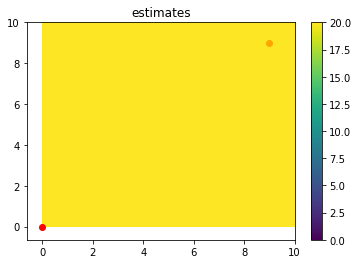

In [5]:
testfield = Field2D(10,10,20)
be = BackhaulEstimator(testfield)

# convenience function for plotting
def plot_field(field, og, dt, estimates=True, vmin=0, vmax=100):
    a=plt.pcolor(field.cost_est if estimates else field.weights, vmin=vmin, vmax=vmax)
    plt.colorbar(a)
    plt.scatter(og[0], og[1], color='orange')
    plt.scatter(dt[0], dt[1], color='red')
    plt.title('estimates' if estimates else 'weights')
    plt.show()
plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Update with our first request, an accepted movement from (4,5) to (5,4) at 50 revenue units.  
Sanity check both contour plot and raw values for both cost estimates and weights.

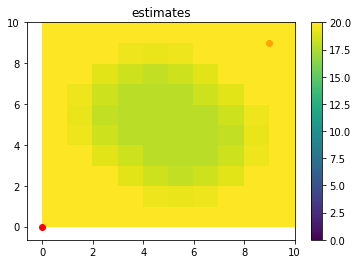

In [6]:
be.update_est((4,5),(5,4),50,True)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

In [7]:
print(testfield.cost_est)

[[20.         20.         20.         20.         20.         20.
  20.         20.         20.         20.        ]
 [20.         20.         20.         20.         19.51078213 19.32332644
  19.51078213 20.         20.         20.        ]
 [20.         20.         20.         19.12513334 18.44086729 18.16817242
  18.44086729 19.12513334 20.         20.        ]
 [20.         20.         19.12513334 18.44086729 17.92893219 17.92893219
  17.92893219 18.44086729 19.51078213 20.        ]
 [20.         19.51078213 18.44086729 17.92893219 17.92893219 17.92893219
  17.92893219 18.16817242 19.32332644 20.        ]
 [20.         19.32332644 18.16817242 17.92893219 17.92893219 17.92893219
  17.92893219 18.44086729 19.51078213 20.        ]
 [20.         19.51078213 18.44086729 17.92893219 17.92893219 17.92893219
  18.44086729 19.12513334 20.         20.        ]
 [20.         20.         19.12513334 18.44086729 18.16817242 18.44086729
  19.12513334 20.         20.         20.        ]
 [20.   

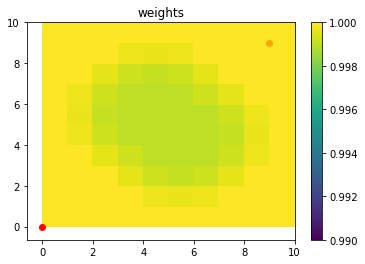

In [8]:
plot_field(testfield, og=(9,9), dt=(0,0), estimates=False, vmin=0.99, vmax=1)

In [9]:
print(testfield.weights)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         0.99976384 0.99967338
  0.99976384 1.         1.         1.        ]
 [1.         1.         1.         0.99957776 0.99924775 0.9991163
  0.99924775 0.99957776 1.         1.        ]
 [1.         1.         0.99957776 0.99924775 0.999001   0.999001
  0.999001   0.99924775 0.99976384 1.        ]
 [1.         0.99976384 0.99924775 0.999001   0.999001   0.999001
  0.999001   0.9991163  0.99967338 1.        ]
 [1.         0.99967338 0.9991163  0.999001   0.999001   0.999001
  0.999001   0.99924775 0.99976384 1.        ]
 [1.         0.99976384 0.99924775 0.999001   0.999001   0.999001
  0.99924775 0.99957776 1.         1.        ]
 [1.         1.         0.99957776 0.99924775 0.9991163  0.99924775
  0.99957776 1.         1.         1.        ]
 [1.         1.         1.         0.99976384 0.99967338 0.99976384
  1.         1.         1.   

Add a few more movements based on the idea that the trucks original origin and destination are around the top right (9,9) and bottom left (0,0), respectively.

First, a path longer, perpendicular to, and cheaper than the first movement that aligns with the original origin/destination path.

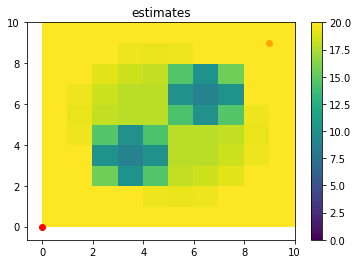

In [10]:
be.update_est((6,6),(3,3),60,True)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Next a rejected request.

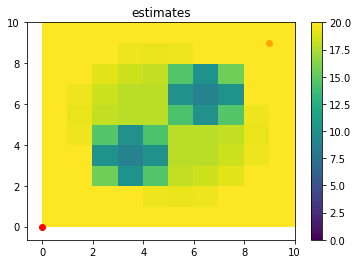

In [11]:
be.update_est((6,3),(3,6),50,False)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Finally a long and expensive rejected request intended to raise estimated costs on the fringe. It doesn't do much since we initialized the weight grid high already.

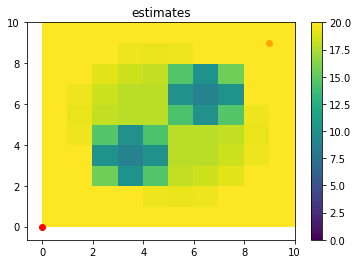

In [12]:
be.update_est((1,8),(8,1),130,False)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

## Randomized, programmatic testing

Now that we've verified that custom-drawn paths work, let's design a testing procedure with random elements that can create randomized requests.

Procedure as follows:
1. Create a square `Field2D` of some `size` and initial cost equivalent to traveling the length `size`, as well as a corresponding `BackhaulEstimator` with some `weight_fcn` and `weight_fcn_aggressive`. Initialize current origin `og` to input `org`.
2. Start accepted requests counter `i` and consequetive rejected requests counter `r` at 0. While `i` is less than input `n`,
    1. Calculate the cost `curcost` to get from current origin `og` to the global endpoint, the input `depot`.
    2. Randomly generate shipping request origin and destination coordinates `rog` and `rdt` from the uniform distribution between `[0,size]`.
    3. Calculate `mincost`, the bare cost to travel from `rog` to `rdt` without accounting for getting from current `og` to `rog` or `rdt` to `depot`.
    4. Generate a price offer `rev` for the request by taking `mincost` and adding a random term scaled between a minimum and maximum distance `random_range` specified by an input
    5. Calculate the actual cost of fulfilling the shipping request by taking `mincost` and adding the cost of traveling from `og` to `rog` and from `rdt` to `depot`.
    6. Check if the carrier will profit from accepting the request, i.e. if the revenue `rev` is greater than the additional cost of accepting the request `ofcost - curcost`.
        1. If so, accept the request, update cost estimates and weights accordingly, and increment the accepted requests counter `i`.
        2. If not, reject the request, update cost estimates and weights accordingly, and increment the consecutive rejected requests counter `r`.
            1. If `r` has reached input `rlim`, reset `r=0` and `og` to the original origin `ogorg`.
    7. For every input `progress_plot_interval` number of requests and when the rejected requests counter `r` is at zero, output a progress plot of the current weight estimates.

Estimated, offered, real cost 516.619037896906 104.89933295830438 214.82587305617932
rejected (7, 7) (17, 1) 104.89933295830438
Estimated, offered, real cost 470.71067811865476 165.73411946434555 102.0498425171809
accepted (14, 19) (7, 18) 165.73411946434555


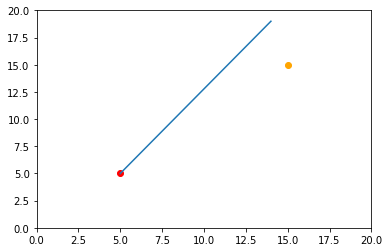

Estimated, offered, real cost 452.7369456659022 66.79803794041052 113.43707551505835
rejected (11, 3) (8, 9) 66.79803794041052
Estimated, offered, real cost 218.3220809678971 94.71749862542242 69.6134823252404
accepted (12, 13) (5, 15) 94.71749862542242


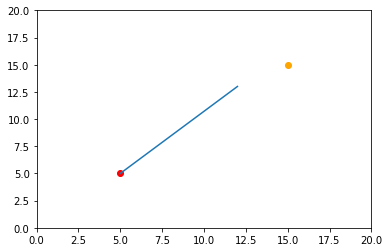

Estimated, offered, real cost 545.6021977856103 190.59044205537504 179.38840978071528
accepted (17, 3) (3, 7) 190.59044205537504


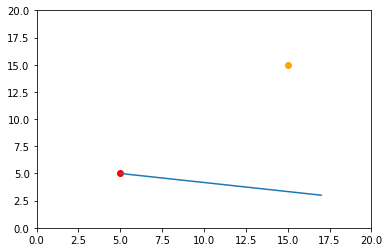

Estimated, offered, real cost 346.0002986908064 73.69274202152968 228.22641564203332
rejected (10, 17) (14, 8) 73.69274202152968
resetting OD


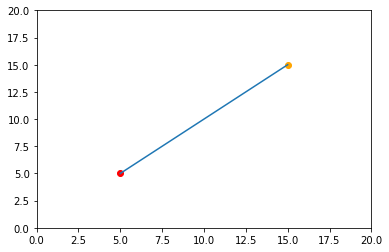

Estimated, offered, real cost 524.1983992205301 297.1630796301004 254.55844122715712
accepted (19, 19) (0, 0) 297.1630796301004


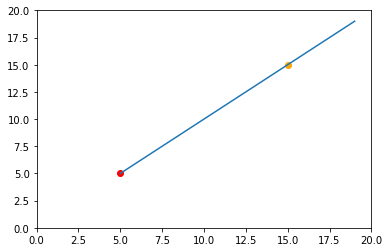

Estimated, offered, real cost 274.489443575981 169.1647848212459 140.79050968614058
accepted (5, 15) (2, 1) 169.1647848212459


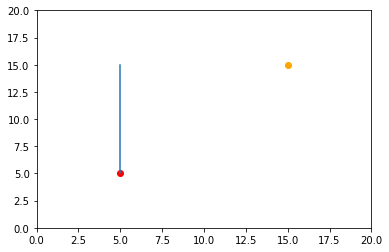

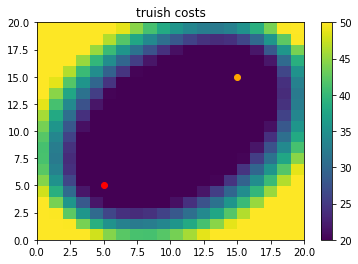

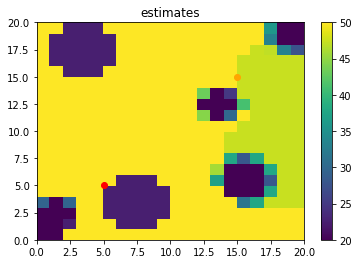

In [13]:
def big_tester(size, n, rlim, ogorg, depot, random_range, weight_fcn, weight_fcn_aggressive, vmin, vmax, log=False, progress_plot_interval=None, debug=False):
    '''
    randomly generate resolved requests and feed them to a BackhaulEstimator with a size^2 Field2Duntil we hit n requests accepted.
    size: length of each edge of the Field2D grid
    n: number of requests to accept before ending the test session
    rlim: number of consecutive requests rejected until the origin is reset to ogorg 
    ogorg: carrier's original origin coordinates
    depot: carrier's depot (final destination)
    random_range: [min, max] additional value (in distance units, to be scaled by a distance-to-cost factor) added to the cost of fulfilling a shipping request (with considering travel to/away from the request)
    weight_fcn, weight_fcn_aggressive: weight updating functions provided to BackhaulEstimator
    progress_plot_interval: how often to output a current-estimate contour plot, by units of requests accepted
    debug: whether or not to show progress messages and plots
    '''

    testfield = Field2D(size,size,size*BackhaulEstimator._BackhaulEstimator__b)
    be = BackhaulEstimator(
            testfield, 
            weight_fcn = weight_fcn, 
            weight_fcn_aggressive = weight_fcn_aggressive
            )
    
    # estimate true cost of each coordinate
    # only calculates cost relative to deviation from the original origin and depot 
    truish_costs = testfield.cost_est.copy()
    og_distance = testfield.get_dist(ogorg, depot)
    for i in range(0,size): # TODO: replace with matrix calculation
        for j in range(0,size):
            coord = (i,j)
            # average of (distance to travel from origin to coord, distance to travel from coord to depot - distance from origin to depot)
            truish_costs[i,j] = .5*(testfield.get_dist(ogorg, coord) + (testfield.get_dist(coord, depot) - og_distance) )*be._BackhaulEstimator__b
    
    total_rmse = []

    i = 0 # requests accepted
    r = 0 # requests rejected since last reassignment

    og = ogorg
    
    plotted = False # flag to prevent duplicate plots

    while i < n:

        # calc current cost to return to depot
        curcost = testfield.get_dist(og, depot)*be._BackhaulEstimator__b

        # randomly generate an OD pair
        rog = (np.random.randint(size), np.random.randint(size))
        rdt = (np.random.randint(size), np.random.randint(size))

        # calculate minimum cost of transporting
        mincost = testfield.get_dist(rog, rdt)*be._BackhaulEstimator__b

        # add random addtl revenue to cover cost of travel
        rev = mincost + (np.random.rand()*(random_range[1]-random_range[0]) + random_range[0])*be._BackhaulEstimator__b

        # calc true cost to fulfill request then return to depot
        ofcost = (testfield.get_dist(og, rog) + testfield.get_dist(rog, rdt) + testfield.get_dist(rdt, depot))*be._BackhaulEstimator__b

        # est cost, offered cost, real cost 
        if debug:
            print('Estimated, offered, real cost', be.get_cost_est(rog, rdt), rev, ofcost-curcost)

        # check if there's profit for carrier
        if rev > (ofcost - curcost):
            # if so, fulfill request and change current origin
            if debug:
                print('accepted', rog, rdt, rev)
            be.update_est(rog, rdt, rev, True);
            og = rog
            i += 1
            
            plotted = False # map has changed so plot it 

            if debug:
                # plot change to od pair
                plt.plot([og[0], depot[0]], [og[1], depot[1]])
                plt.scatter(ogorg[0], ogorg[1], color='orange')
                plt.scatter(depot[0], depot[1], color='red')
                plt.ylim(0,size)
                plt.xlim(0,size)
                plt.show()
                
        else: # reject request
            if debug:
                print('rejected', rog, rdt, rev)
            be.update_est(rog, rdt, rev, False);
            r += 1

            # reset trajectory if there have been more than 10 rejected requests
            if r >= rlim:
                r = 0
                og = ogorg
                
                if debug:
                    print('resetting OD')
                    # plot graph after return to original OD pair
                    plt.plot([og[0], depot[0]], [og[1], depot[1]])
                    plt.scatter(ogorg[0], ogorg[1], color='orange')
                    plt.scatter(depot[0], depot[1], color='red')
                    plt.ylim(0,size)
                    plt.xlim(0,size)
                    plt.show()
        
        # despite debug, plot progress every progress_plot_interval accepted requests if the rejection counter has reset
        if progress_plot_interval and (i%progress_plot_interval == 0) and (not plotted):
            f, (est, err) = plt.subplots(1, 2)
            f.set_size_inches(10, 4)
            
            # plot cost estimates
            if log:
                a = est.pcolor(testfield.cost_est, norm=LogNorm(vmin=vmin, vmax=vmax))
            else:
                a = est.pcolor(testfield.cost_est, vmin=vmin, vmax=vmax)
            f.colorbar(a, ax=est)
            est.scatter(ogorg[0], ogorg[1], color='orange')
            est.scatter(depot[0], depot[1], color='red')
            est.set_title('estimates at i={}'.format(i))
            
            # calculate RMSE, print total RMSE, and plot
            rmse = np.sqrt((truish_costs - testfield.cost_est)**2)
            total_rmse.append(np.sum(np.sum(rmse)))
            print('Total RMSE: {}'.format(total_rmse[-1]))
            b = err.pcolor(rmse, vmin=vmin, vmax=vmax)
            f.colorbar(b, ax=err)
            err.scatter(ogorg[0], ogorg[1], color='orange')
            err.scatter(depot[0], depot[1], color='red')
            err.set_title('RMSE at i={}'.format(i))
            plt.show()
            
            plotted = True # we've plotted so we don't need to replot unless something changes
    
    # plot truish costs to compare
    a = plt.pcolor(truish_costs, vmin=vmin, vmax=vmax)
    plt.colorbar(a)
    plt.scatter(ogorg[0], ogorg[1], color='orange')
    plt.scatter(depot[0], depot[1], color='red')
    plt.title('truish costs')
    plt.show()
    
    if progress_plot_interval and :
        # plot total RMSE over iterations
        plt.plot(np.arange(0, n, progress_plot_interval), np.log(total_rmse))
        plt.title('log(RMSE) vs. iterations')
        plt.xlabel('Iteration')
        plt.ylabel('log(RMSE)')
        plt.show()
    
    return testfield

size = 20

# set original params
ogorg = (15,15)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

plot_field(
    big_tester(size, 5, 3, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50, debug=True), 
    og=ogorg, 
    dt=depot, 
    vmin=20, 
    vmax=50)

Debug mode verifies that at least our costing and origin/destination reassignment is working as intended.

# The real test

We're defaulting to weight functions of the form $$w' = \frac{w}{1 + (1-d)\times 10^{c}}$$ where $d$ is the normalized distance outside the circle (for coordinates in `outer`) and $c$ is $-4$ for normal weight updates and $-3$ for aggressive ones.

We're randomizing the revenue above the bare cost to travel from request origin to request origin between $[-\frac{1}{4},\frac{1}{2}]$ the size of the field for two reasons:
1. minimum is negative to account for the possibility of the request to align with the direction of travel from original origin and destination,
2. maximum is $\frac{1}{2}$ since it seems like generally the maximum cost to travel from any arbitrary origin to any arbitrary destination plus the reverse. (Really it just felt right.)

Total RMSE: 69113.14401074944


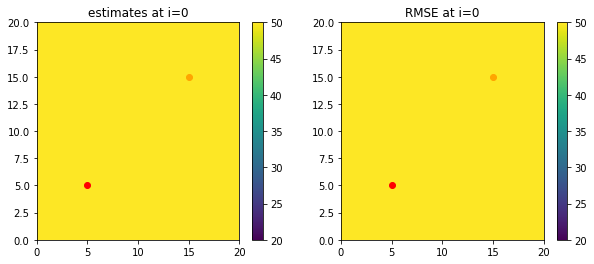

Total RMSE: 6920.154721397284


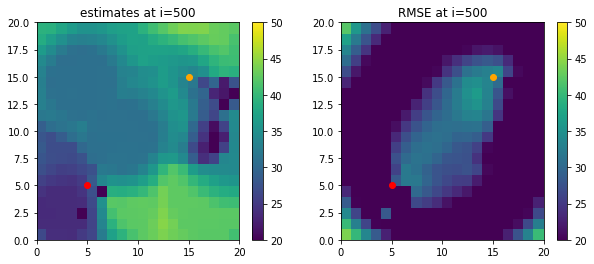

Total RMSE: 7019.512497669023


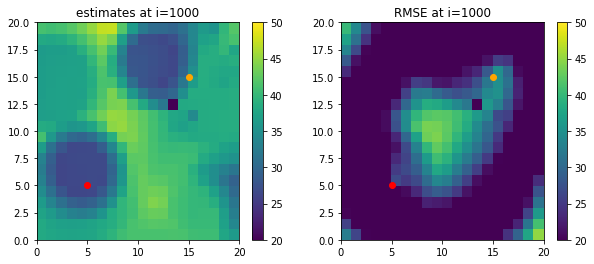

Total RMSE: 8888.586142694727


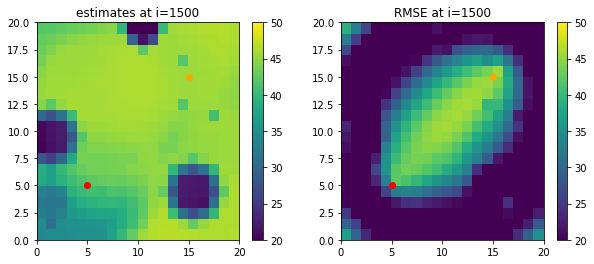

Total RMSE: 7036.615183970798


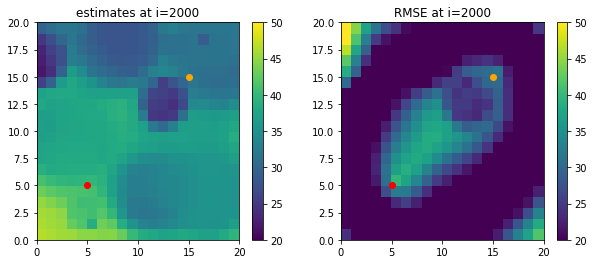

Total RMSE: 6197.042273914549


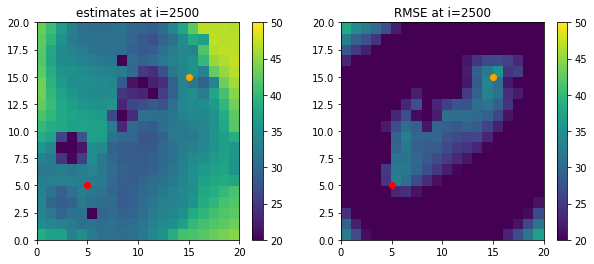

Total RMSE: 7884.180860581864


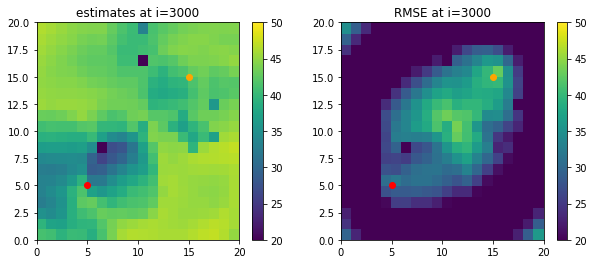

Total RMSE: 7916.207378942094


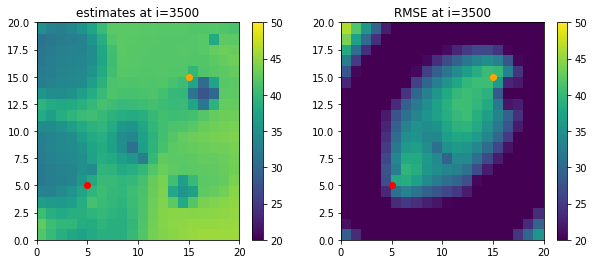

Total RMSE: 6621.959153056907


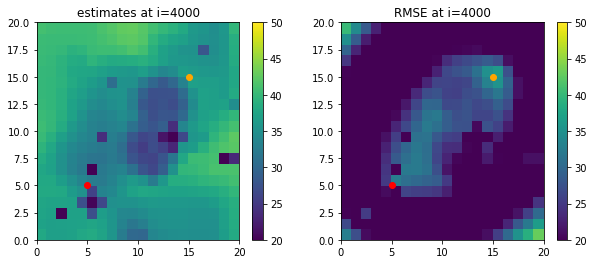

Total RMSE: 7854.358703143362


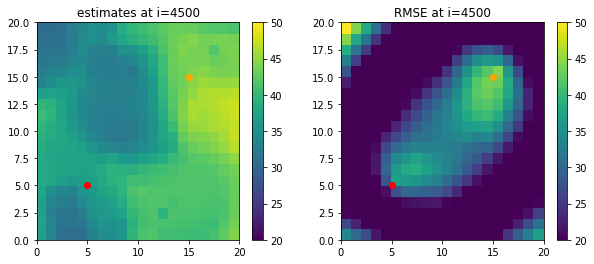

Total RMSE: 7549.528129705315


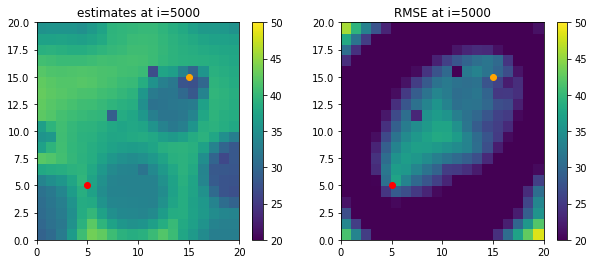

Total RMSE: 7481.683822197812


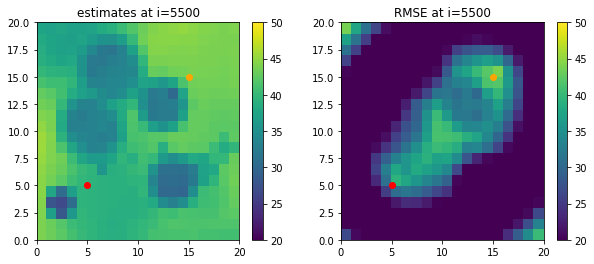

Total RMSE: 7727.581858417733


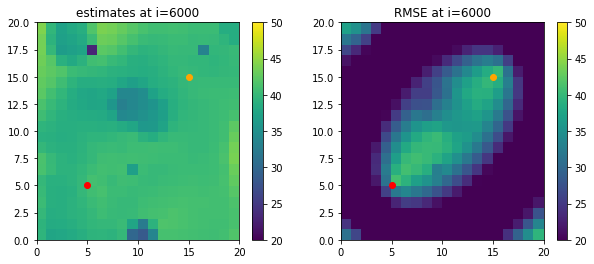

Total RMSE: 6826.962300299021


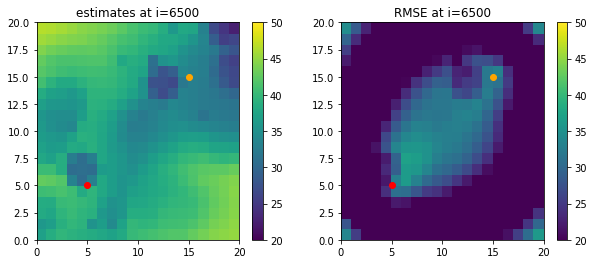

Total RMSE: 6583.364267768846


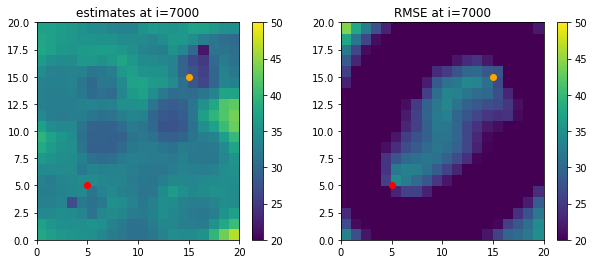

Total RMSE: 7249.4893809900395


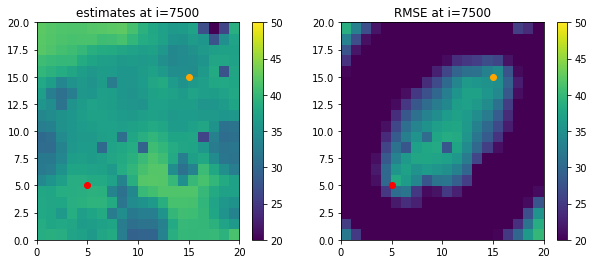

Total RMSE: 6767.6792265215045


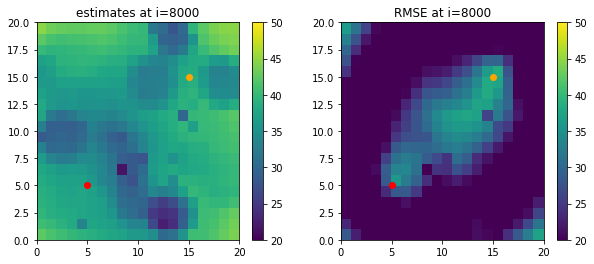

Total RMSE: 7632.453551680368


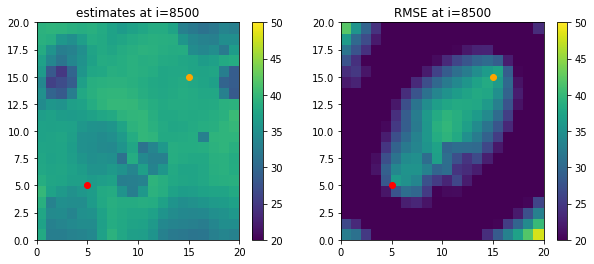

Total RMSE: 6951.251874284871


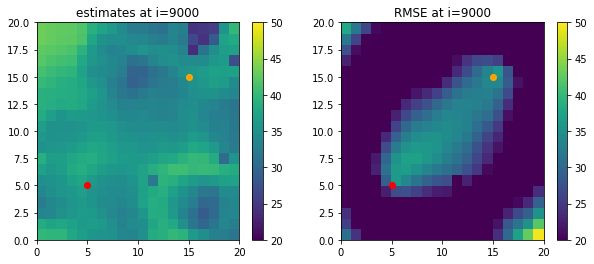

Total RMSE: 7087.954808171941


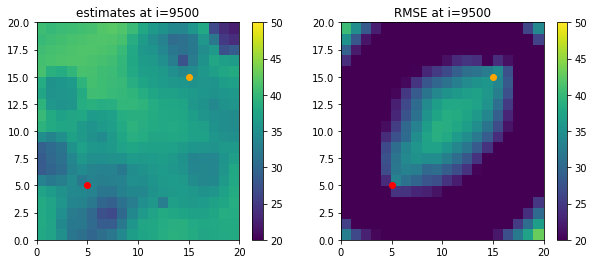

Total RMSE: 7518.411311566857


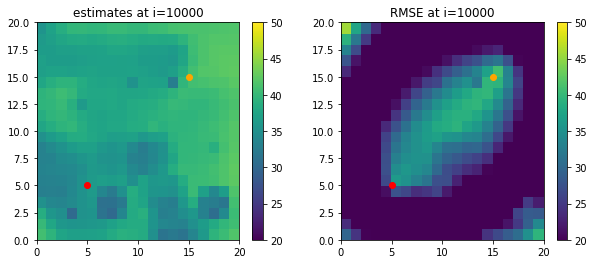

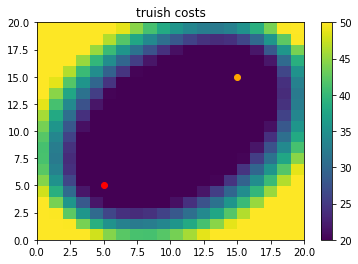

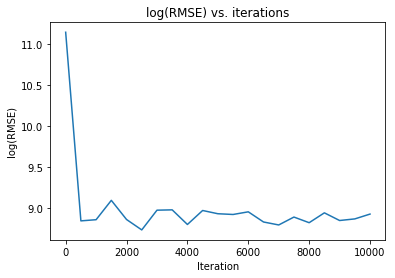

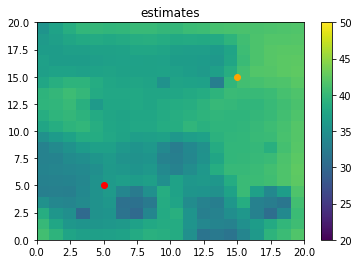

In [14]:
size = 20

# set original params
ogorg = (15,15)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50, progress_plot_interval=500)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

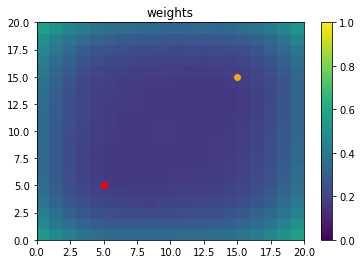

In [15]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

## Try less sensitive weight functions

Estimates appear to be too bouncy. Freeze estimates sooner.

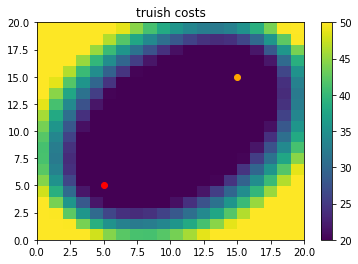

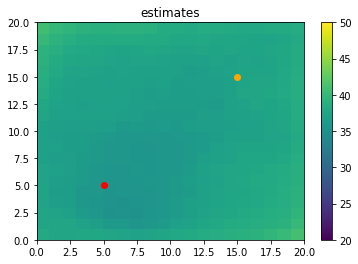

In [16]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .01*(1-d) )) )

field = big_tester(size, 10001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

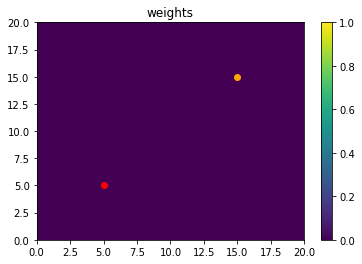

In [17]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

The entire field's estimates coalesced into basically the same value, but if you squint you can see that there is some variance in a way that we'd expect.

## Fewer iterations?

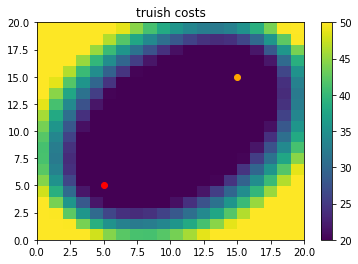

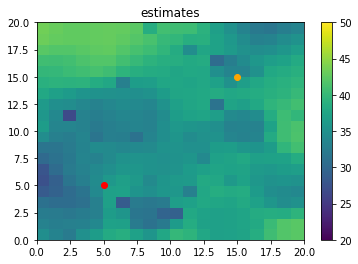

In [19]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .01*(1-d) )) )

field = big_tester(size, 1001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

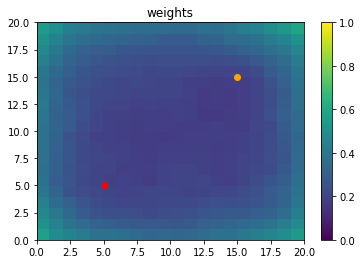

In [20]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

There just isn't enough variation in our cost estimates.

## Fewer rejected requests before reset?

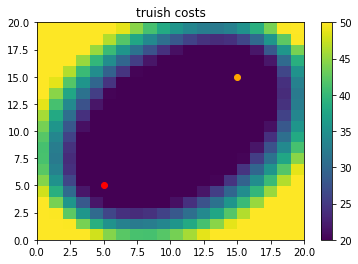

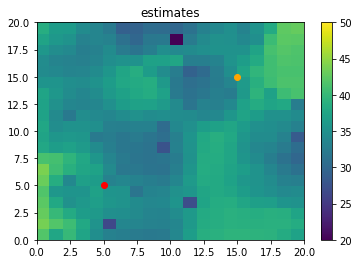

In [21]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 2, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

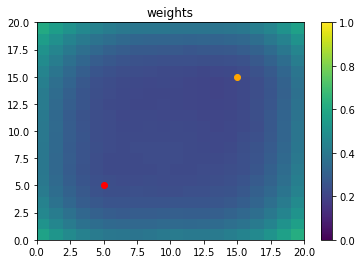

In [22]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

The cost estimates don't look right. What about tossing the reset counter entirely?

## No consecutive matches

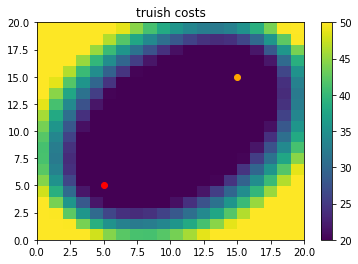

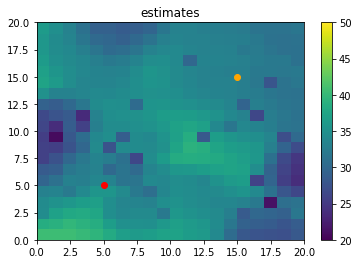

In [23]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 0, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

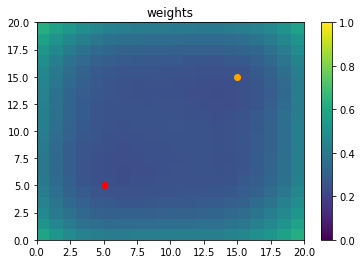

In [24]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

Estimate field still doesn't vary enough/as expected.

## Larger field with smaller things

Total RMSE: 170673.54531812295


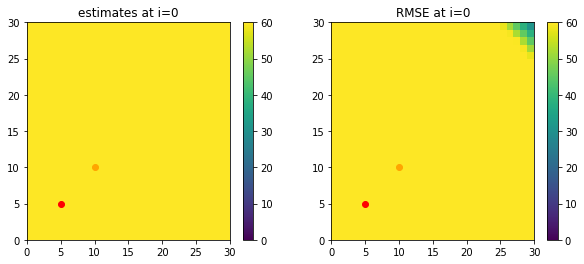

Total RMSE: 56170.48616503568


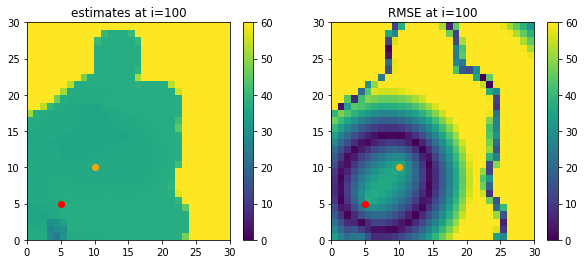

Total RMSE: 55375.73491056584


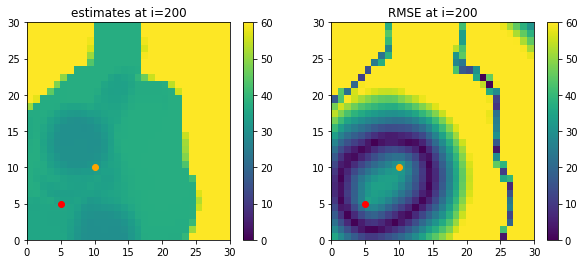

Total RMSE: 52948.70469826648


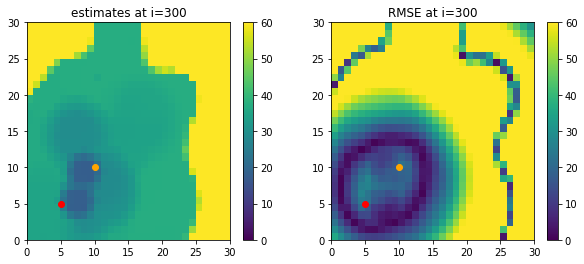

Total RMSE: 53467.08898582621


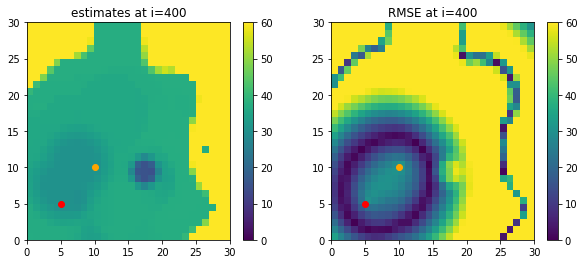

Total RMSE: 55055.97341107871


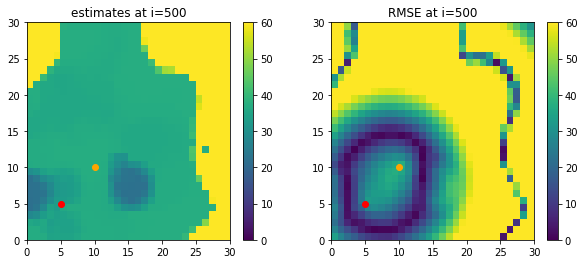

Total RMSE: 55385.65517000132


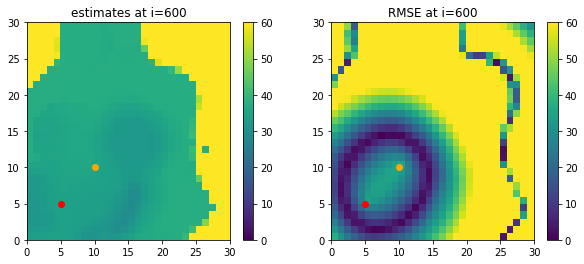

Total RMSE: 59377.44183250945


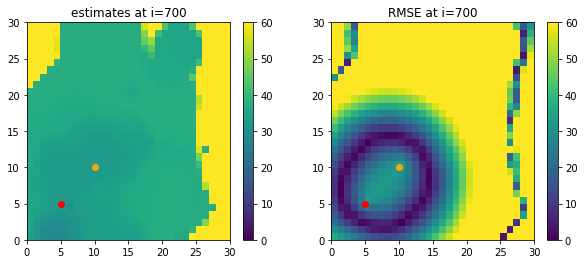

Total RMSE: 59140.86221532837


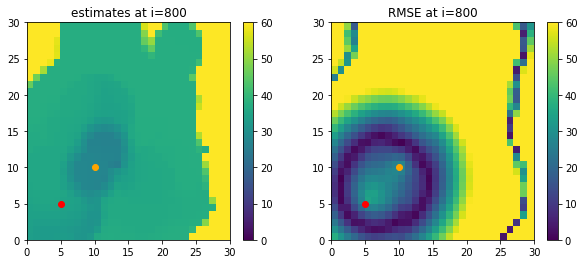

Total RMSE: 59524.249148903575


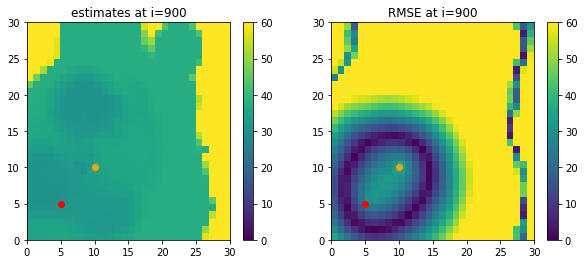

Total RMSE: 59613.80839045462


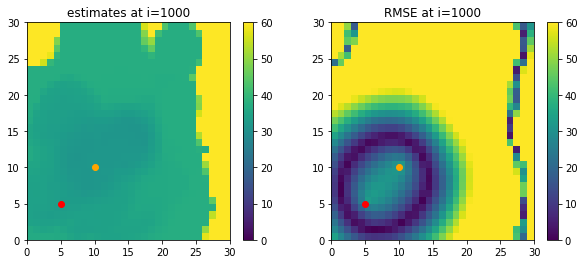

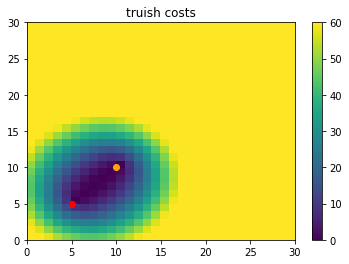

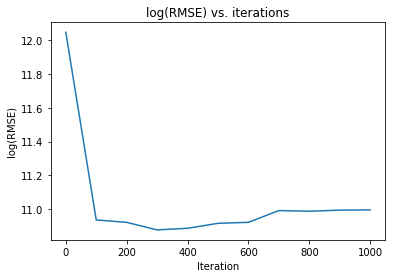

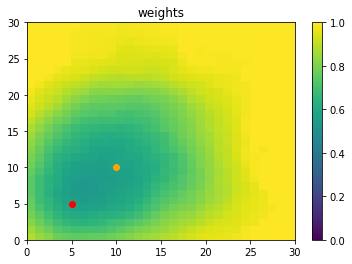

In [25]:
size = 30

# set original params
ogorg = (10,10)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

# colorbar minmax
vmin = 0
vmax = 60

field = big_tester(size, 1001, 5, ogorg, depot, (-1*size/8, size/4), weight_fcn, weight_fcn_aggressive, vmin=vmin, vmax=vmax, log=False, progress_plot_interval=100)
# plot_field(field, og=ogorg, dt=depot, vmin=vmin, vmax=vmax)
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

Not sure about this one. I had to narrow the colorbar window a lot to get it to look reasonable, but at least it finally looks like what we'd expect.

# Conclusions

No idea.